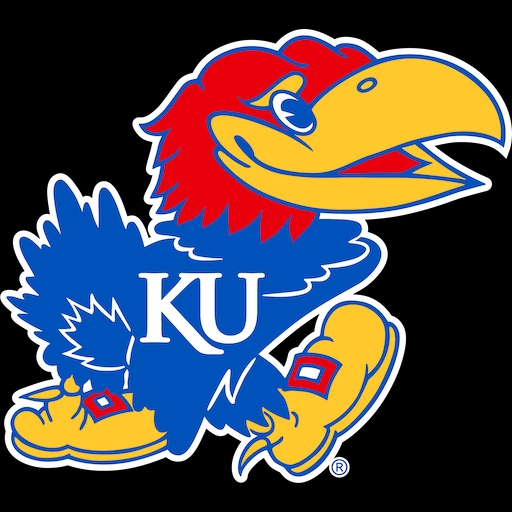

In [17]:
from pathlib import Path
from PIL import Image
import numpy as np
from sympy import Matrix

filename = Path("../img/color/Jayhawk_512x512x3.jpg")

with Image.open(filename, "r") as im:
    display(im)

# True for noisy execution, False for noiseless execution
noisy_execution = False
draw_qc = True

In [18]:
def display_quantum_circuit(qc):
    if draw_qc:
        display(qc.draw('mpl', reverse_bits=True))
        
def display_matrix(matrix):
    try:
        display(Matrix(matrix))
    except:
        print(matrix)

In [19]:
from qcc.quantum import flatten_image, normalize, to_qubits

psi, *dims = flatten_image(filename, pad=True)
psi, mag = normalize(psi, include_magnitude=True)

dims_q = [to_qubits(x) for x in dims]

num_qubits = sum(dims_q)
num_states = 2**num_qubits

In [20]:
from itertools import zip_longest

decomposition_levels = [2, 2]
dims_out = [d // (2**l) for d, l in zip_longest(dims, decomposition_levels, fillvalue=0)]

dims_out

[128, 128, 3]

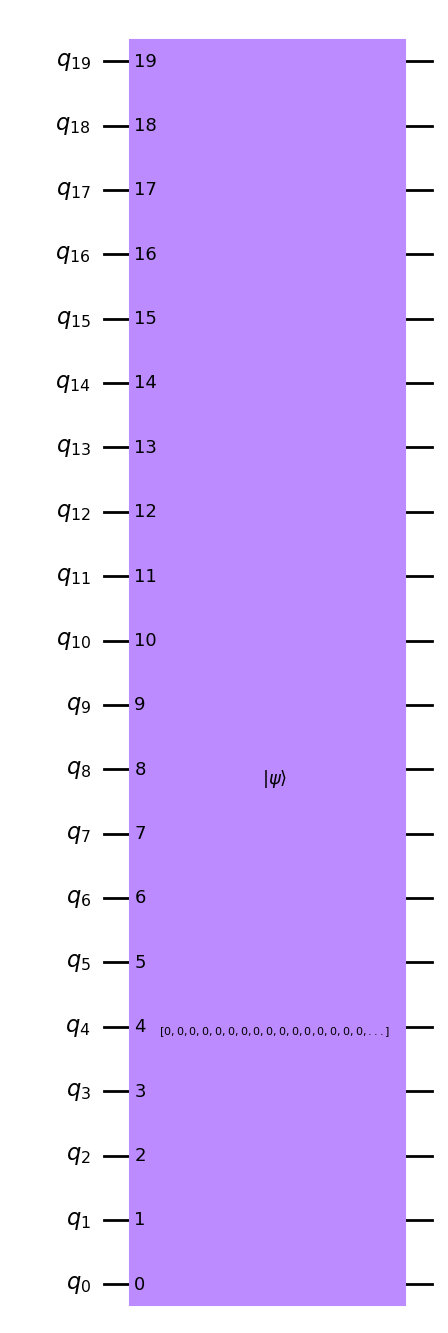

In [21]:
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator

qc = QuantumCircuit(num_qubits)
qc.initialize(psi)

display_quantum_circuit(qc)

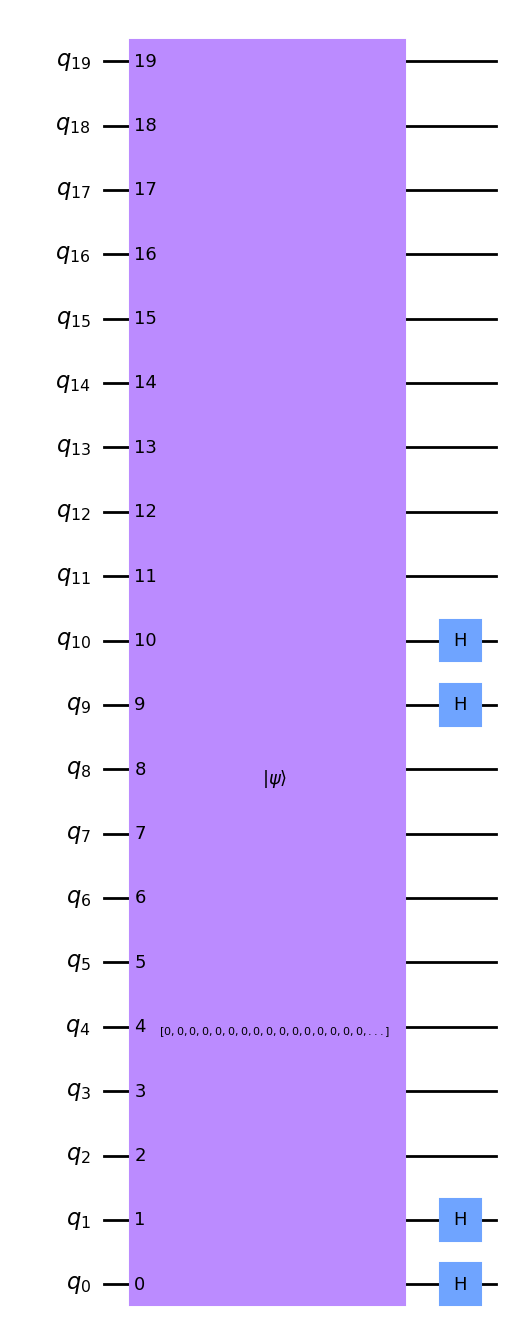

In [22]:
base = np.hstack(([0], np.cumsum(dims_q[:-1])))

for q, l in zip(base, decomposition_levels):
    qc.h(qc.qubits[q:q+l])

display_quantum_circuit(qc)

In [23]:
def rotate_right(qc: QuantumCircuit, q1: int, q2: int):
    for i in range(q1, q2-1):
        qc.swap(i, i+1)

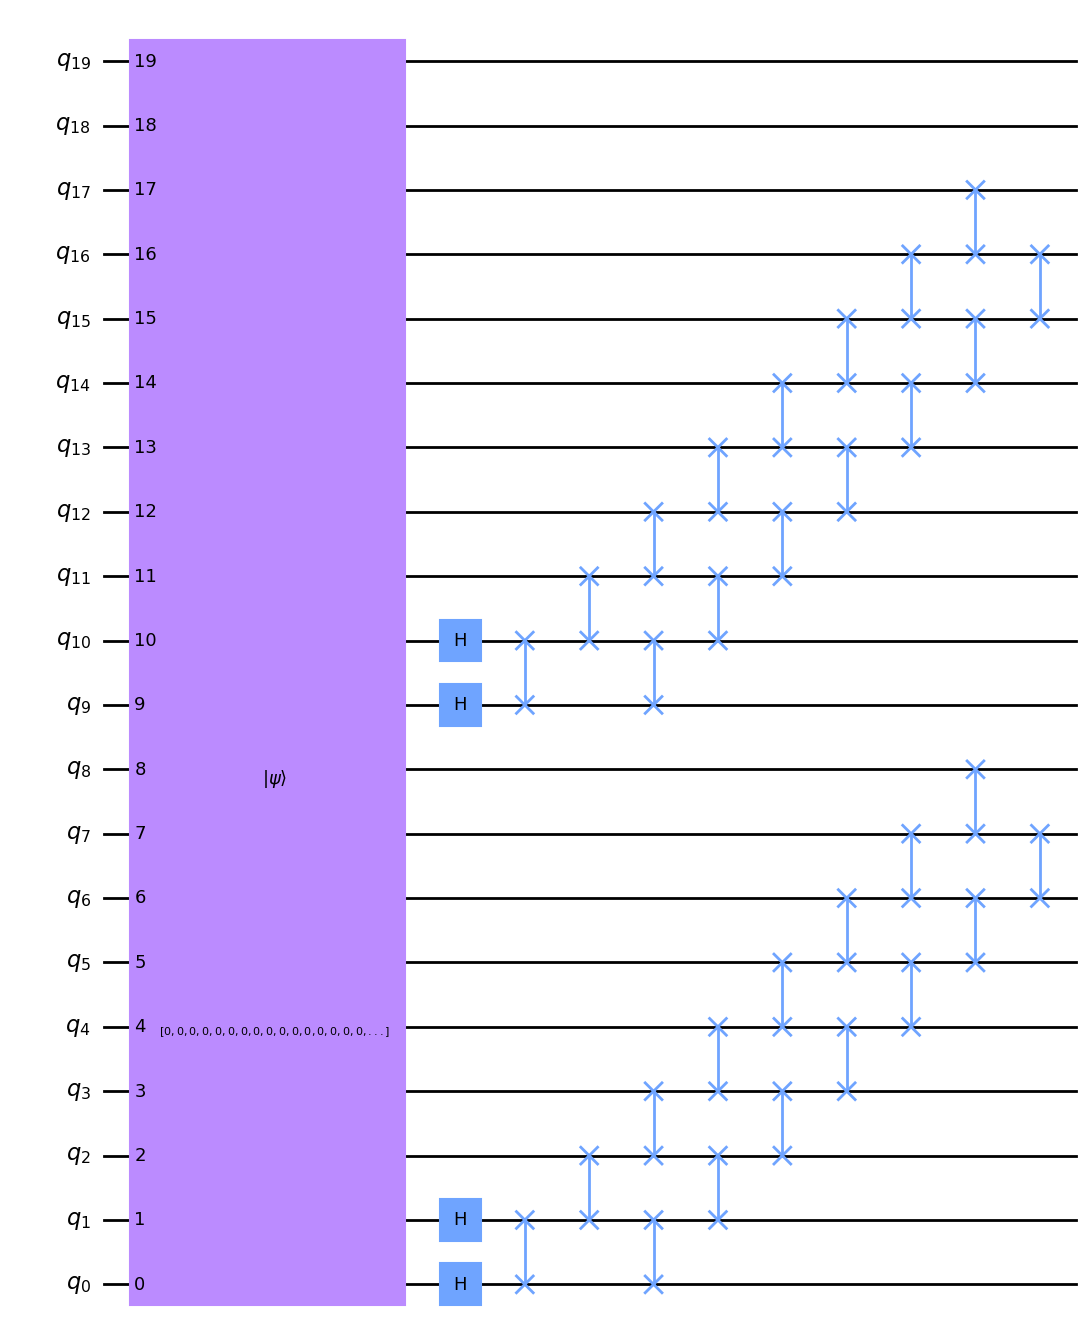

In [24]:
top = np.cumsum(dims_q)
for b, t, l in zip(base, top, decomposition_levels):
    for i in range(l):
        rotate_right(qc, b, t-i)
        
display_quantum_circuit(qc)

In [25]:
from qiskit import Aer, execute
from qiskit.tools import job_monitor
from qcc.quantum import from_counts

backend = Aer.get_backend('aer_simulator')
shots = backend.configuration().max_shots

if noisy_execution:
    qc.measure_all()
else:
    qc.save_statevector()

job = execute(qc, backend=backend, shots=shots)
job_monitor(job)

result = job.result()

if noisy_execution:
    counts = result.get_counts(qc)
    psi_out = from_counts(counts, shots=shots, num_qubits=num_qubits)
else:
    psi_out = result.get_statevector(qc).data

Job Status: job has successfully run


In [26]:
from qcc.quantum import reconstruct

img = psi_out.data
norm = mag / np.sqrt(2**sum(decomposition_levels))

print(min(np.abs(norm*img)), max(np.abs(norm*img)))

0.0 254.99999999999997


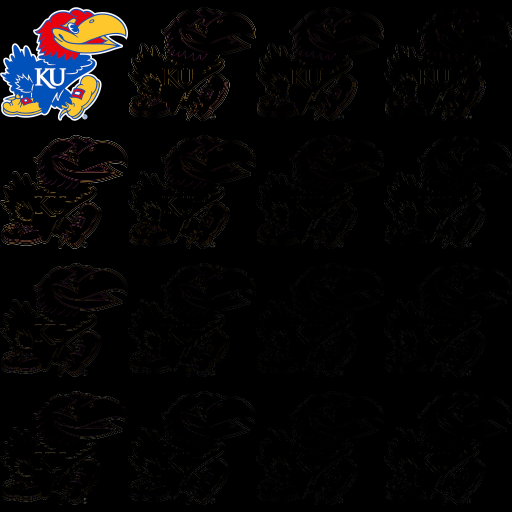

In [27]:
img_full = reconstruct(norm*img, dims)
img_full = Image.fromarray(np.abs(img_full).astype(np.uint8))
img_full.save("output_full.png")

display(img_full)

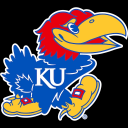

In [28]:
img_decomposed = reconstruct(norm*img, dims, dims_out)
img_decomposed = Image.fromarray(np.abs(img_decomposed).astype(np.uint8))
img_decomposed.save("output_decomposed.png")

display(img_decomposed)

### Quantum Reconstruction

In [29]:
# qc = qc.copy_empty_like()

# psi_new, *_ = flatten_image(img_decomposed, pad=True)
# psi_new, _ = normalize(psi_new, include_magnitude=True)

In [30]:
# initialize = []
# h = []
# for q, t, l in zip_longest(base, top, decomposition_levels, fillvalue=0):
#     h += qc.qubits[q:q+l]
#     initialize += qc.qubits[q+l:t]
    
# qc.initialize(psi_new, initialize)
# qc.h(h)

# display_quantum_circuit(qc)

In [31]:
# if noisy_execution:
#     qc.measure_all()
# else:
#     qc.save_statevector()

# job = execute(qc, backend=backend, shots=shots)
# job_monitor(job)

# result = job.result()

# if noisy_execution:
#     counts = result.get_counts(qc)
#     psi_out = from_counts(counts, shots=shots, num_qubits=num_qubits)
# else:
#     psi_out = result.get_statevector(qc).data

In [32]:
# img_reconstructed = reconstruct(mag*psi_out.data, dims)
# img_reconstructed = Image.fromarray(np.abs(img_reconstructed).astype(np.uint8))
# img_reconstructed.save("output_reconstructed.png")

# display(img_reconstructed)

### Classical Results

(128, 128, 3) 0.0 255.00000000000006


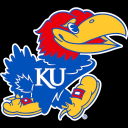

In [33]:
from pywt import wavedec

with Image.open(filename, "r") as im:
    classical_img = np.asarray(im, dtype=float)

for i, l in enumerate(decomposition_levels):
    classical_img = wavedec(classical_img, "haar", "zero", level=l, axis=i)[0] / l
    
print(classical_img.shape, min(classical_img.flatten()), max(classical_img.flatten()))
    
classical_img = classical_img.astype(np.uint8)
classical_img = Image.fromarray(classical_img)
display(classical_img)
classical_img.save("output_classical.png")

In [34]:
from qcc.quantum import get_fidelity

fid = get_fidelity(np.asarray(classical_img).flatten(), np.asarray(img_decomposed).flatten())

print(f"Fidelity: {fid:.03%}")

Fidelity: 100.000%
